## Clustering Chords

Using relative alignment scores as similarity measures.

In [1]:
import pandas as pd
import numpy as np
from sklearn import manifold
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
import networkx as nx
import community

### Create similarity matrix

In [25]:
# load calculated alignment table
scoresDat = pd.read_csv('calculations/smith_waterman.zip')

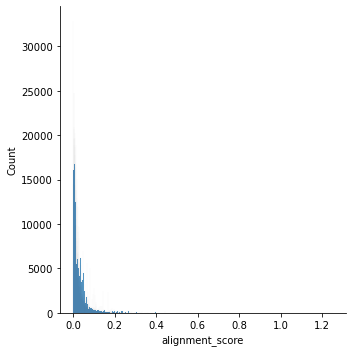

In [26]:
sns.displot(data=scoresDat, x='alignment_score')

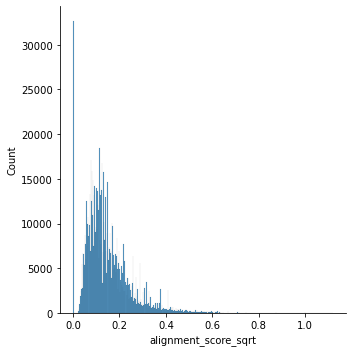

In [27]:
sns.displot(data=scoresDat, x='alignment_score_sqrt')

In [29]:
dat = scoresDat

In [30]:
names = sorted(list(set(np.concatenate((dat['tune1_name'].values , dat['tune2_name'].values)))))
simM = np.diag(np.full((1,len(names)), 0)[0])
simM = simM.astype('float64')
simM.shape

(1334, 1334)

In [33]:
sc = dat['alignment_score_sqrt'].values
k = 0
for i in range(len(names)):
    for j in range(i+1,len(names)-1):
        simM[i,j] = sc[k]
        simM[j,i] = sc[k]
        k += 1
    k += 1

## knn matrix

In [32]:
# creates weighted kNN graph according to Phenograph
def MakeKNN(k, simM, sim_cutoff = 0):
    
    sim = np.copy(simM)
    sim[sim < sim_cutoff] = 0
    
    knnS = np.zeros((sim.shape[0], k))
    
    for i in range(sim.shape[0]):
        if max(sim[i,:]) == 0:
            ind = np.zeros(k)
        else:
            s = np.sort(sim[i,np.where(sim[i,:] > 0)[0]])
            if len(s) < k:
                cut = s[0]
            else:
                cut = s[-k]
            ind = np.where(sim[i,:] >= cut)[0]+1 # add 1 to differentiate 0 position
        if len(ind) > k: # if ties, sample randomly (not ideal as sampling is from all)
            ind = np.random.choice(ind, k, replace=False)
        elif len(ind) < k:
            ind = np.concatenate((ind, np.zeros(k-len(ind))))
        knnS[i,:] = ind
    
    knnM = np.zeros(sim.shape)
    for i in range(sim.shape[0]):
        for j in range(i+1, sim.shape[0]-1):
            # set weight according to number of common neighbors
            if max(knnS[i,:]) == 0 or max(knnS[j,:]) == 0:
                knnM[i,j] = knnM[j,i] = 0
            else:
                knnM[i,j] = knnM[j,i] = len(set(knnS[i,:]).intersection(set(knnS[j,:]))) / len(set(knnS[i,:]).union(set(knnS[j,:])))
    
    return knnM

In [34]:
kn5M = MakeKNN(5, simM, 0.01)

In [35]:
# remove rows with no connections as they make clustering the graph harder

rem = []
for i in range(kn5M.shape[0]):
    if max(kn5M[i,:])!=0:
        rem.append(i)
rem = np.array(rem)
kn5M = kn5M[rem,:]
kn5M = kn5M[:,rem]

## kNN graph

In [36]:
G5 = nx.from_numpy_matrix(kn5M)

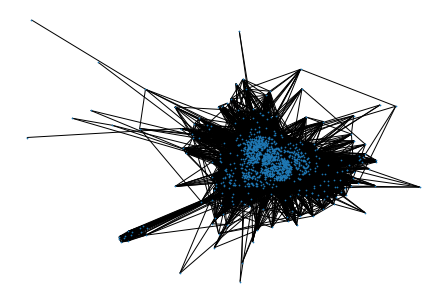

In [37]:
nx.draw(G5, node_size=0.5)

In [38]:
p5 = community.best_partition(G5)

In [39]:
max(p5.values())

6

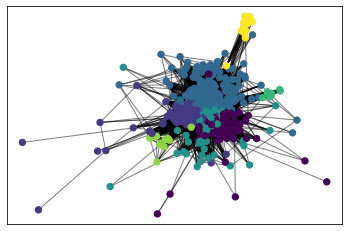

In [40]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt

# draw the graph
pos = nx.spring_layout(G5)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(p5.values()) + 1)
nx.draw_networkx_nodes(G5, pos, p5.keys(), node_size=40,
                       cmap=cmap, node_color=list(p5.values()))
nx.draw_networkx_edges(G5, pos, alpha=0.5)
plt.show()

In [44]:
p5.values()

dict_values([1, 1, 1, 2, 3, 2, 2, 2, 1, 1, 1, 3, 3, 2, 2, 1, 2, 1, 3, 2, 2, 3, 3, 1, 2, 1, 1, 2, 2, 3, 1, 2, 2, 0, 1, 1, 1, 3, 3, 1, 2, 2, 1, 1, 3, 3, 3, 0, 1, 2, 1, 1, 1, 3, 0, 0, 2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 2, 2, 1, 5, 3, 1, 1, 3, 2, 1, 1, 0, 1, 1, 6, 1, 3, 1, 2, 1, 2, 1, 3, 2, 2, 2, 2, 4, 2, 1, 1, 2, 0, 3, 1, 0, 1, 3, 1, 0, 2, 0, 3, 2, 2, 2, 1, 1, 1, 3, 0, 2, 1, 0, 1, 1, 5, 1, 0, 3, 0, 2, 2, 1, 0, 1, 2, 2, 2, 1, 2, 0, 1, 4, 2, 5, 3, 1, 3, 0, 1, 1, 2, 1, 1, 0, 2, 2, 1, 2, 1, 1, 1, 2, 2, 2, 1, 2, 2, 3, 0, 2, 2, 2, 1, 0, 0, 0, 2, 1, 1, 1, 1, 1, 2, 0, 2, 1, 2, 0, 2, 1, 2, 2, 2, 1, 1, 1, 2, 3, 0, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 3, 0, 2, 0, 2, 1, 3, 2, 2, 4, 3, 0, 2, 1, 1, 2, 2, 1, 2, 3, 1, 0, 2, 2, 2, 3, 1, 3, 1, 0, 2, 3, 3, 1, 2, 3, 3, 1, 1, 1, 0, 3, 3, 0, 3, 1, 2, 3, 1, 2, 0, 3, 3, 2, 2, 1, 0, 2, 2, 0, 2, 1, 2, 2, 1, 1, 1, 3, 2, 2, 2, 2, 0, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 5, 3, 3, 2, 2, 1, 1, 3, 0, 2, 2, 6, 2, 3, 3, 2, 1, 3, 3, 2, 2, 2, 1, 1, 3, 3, 0, 1, 1, 1, 3, 2, 2, 2, 1, 3, 2, 